# 03 — Modeling

**Goal:** build a simple, readable baseline classifier (Logistic Regression) on the **cleaned** Titanic data and evaluate it.

**Plan**
- Load the cleaned dataset from `02`  
- Feature engineering for ML (FamilySize, encodings)  
- Select features & target, train/test split (with stratify)  
- Train Logistic Regression (baseline)  
- Evaluate: accuracy, precision/recall/F1, confusion matrix (heatmap)  
- Save artifacts (metrics JSON + figures) for `04_results`


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import json


### Load cleaned data

We use the output from **02** so modeling is reproducible and not tied to raw-data quirks.


In [4]:
df_clean = pd.read_csv("../data/processed/titanic_cleaned.csv")
print("Cleaned shape:", df_clean.shape)
df_clean.head(3)

Cleaned shape: (891, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Feature engineering (for modeling)

Transform categorical features into numbers and create a useful aggregate:

- **FamilySize** = `SibSp + Parch + 1` (solo = 1, larger number = bigger group)
- **Sex** → numeric (`male=0`, `female=1`)
- **Embarked** → one-hot dummies (drop the first to avoid redundancy)


In [5]:
df_model = df_clean.copy()

# Family size
df_model["FamilySize"] = df_model["SibSp"] + df_model["Parch"] + 1

# Encode Sex
df_model["Sex"] = df_model["Sex"].map({"male": 0, "female": 1})

# One-hot encode Embarked (drop_first to avoid dummy trap)
df_model = pd.get_dummies(df_model, columns=["Embarked"], drop_first=True)

# Quick check
df_model.filter(["Sex","Pclass","Age","Fare","FamilySize","Embarked_Q","Embarked_S","Survived"]).head(3)


,Sex,Pclass,Age,Fare,FamilySize,Embarked_Q,Embarked_S,Survived
0,0,3,22.0,7.2500,2,False,True,0
1,1,1,38.0,71.2833,2,False,False,1
2,1,3,26.0,7.9250,1,False,True,1


### Select features and train/test split

We pick simple, interpretable signals:
`Pclass, Sex, Age, Fare, FamilySize, Embarked_Q, Embarked_S`.

Use an **80/20** split with `stratify=y` so survival ratio is preserved in train/test.


In [6]:
feature_cols = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "Embarked_Q", "Embarked_S"]
X = df_model[feature_cols]
y = df_model["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((712, 7), (179, 7))

### Train a Logistic Regression baseline

Logistic Regression is a solid, quick baseline for binary classification.  
We increase `max_iter` to ensure convergence.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  


In [9]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))
print("ROC-AUC  :", round(auc, 3))

Accuracy : 0.793
Precision: 0.767
Recall   : 0.667
F1-score : 0.713
ROC-AUC  : 0.84


### Confusion Matrix (heatmap)

Why: raw numbers are hard to scan; a heatmap makes errors and correct predictions obvious at a glance.

What to look for:
- **Top-left (TN):** correctly predicted *did not survive*
- **Bottom-right (TP):** correctly predicted *survived*
- **Off-diagonals (FP/FN):** mistakes

We’ll also **save the figure** to `reports/figures/confusion_matrix.png` so it shows up in the repo and can be reused in the results notebook.


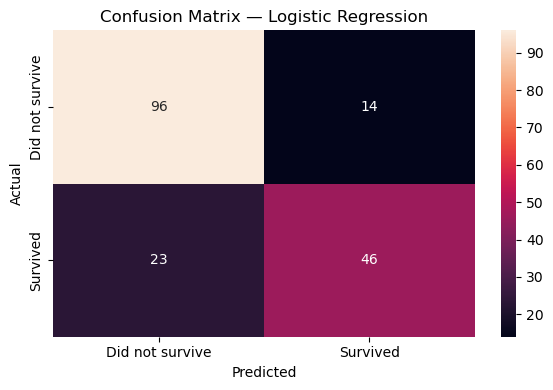

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Did not survive", "Survived"],
            yticklabels=["Did not survive", "Survived"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


### Save metrics for the results notebook

Why: storing metrics in a small JSON file lets us **reuse** them in `04_results.ipynb` and keeps results reproducible.

Saved fields:
- `accuracy`, `precision`, `recall`, `f1`, `roc_auc`
- optional counts (train/test sizes) and the list of features

Output path: `reports/metrics.json`


In [11]:
import json

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1),
    "roc_auc": float(auc)
}
with open("../reports/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved: ../reports/metrics.json")


Saved: ../reports/metrics.json
